## Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD, NMF
from umap import UMAP

import torch
# import torch.nn as nn
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader

from torchvision import transforms, datasets

from tqdm import tqdm

## 設定

In [2]:
ID = 'rowID'
TARGET = 'Objective Variable_CL(L/hr/kg)'
TARGET_LOG = 'Objective Variable_CL(L/hr/kg)_Log'

TRAIN_PATH = '../data/train_fps.csv'
TEST_PATH = '../data/test_fps.csv'

# BATCH_SIZE= 460

## データ用意

In [3]:
df_train = pd.read_csv(TRAIN_PATH)
df_test = pd.read_csv(TEST_PATH)
df_train.rename(columns={TARGET: 'y', TARGET_LOG: 'logy', ID:'ID'}, inplace=True)
df_test.rename(columns={ID:'ID'}, inplace=True)

X = df_train.drop(['ID', 'y', 'logy'], axis=1)
y = df_train.logy
print(X.shape, y.shape)

(1379, 2048) (1379,)


## 前処理

NMFが一番性能悪い  
SVDもUMAPもそんなに変わらんという感触

In [4]:
# svd = TruncatedSVD(n_components=5, n_iter=7, random_state=42)
# X = svd.fit_transform(X)

In [4]:
# um = UMAP(n_components=5)
# X = um.fit_transform(X)

In [5]:
nmf = NMF(n_components=5, init='random', random_state=71)
X = nmf.fit_transform(X)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.5, shuffle=True, random_state=12)

inps_train = torch.from_numpy(X_train)
tgts_train = torch.from_numpy(y_train.values).view(-1, 1)
inps_test = torch.from_numpy(X_test)
tgts_test = torch.from_numpy(y_test.values).view(-1, 1)

In [7]:
inps_train.size(), tgts_train.size(), inps_test.size(), tgts_test.size()

(torch.Size([689, 5]),
 torch.Size([689, 1]),
 torch.Size([690, 5]),
 torch.Size([690, 1]))

## CNN

In [8]:
D_IN = inps_train.size()[1]
D_OUT = tgts_train.size()[1]

N_EPOCH = 1000
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [9]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [10]:
class ConvLayer(nn.Module):
    def __init__(self, in_chan, out_chan, kernel_size=3, stride=1):
        super().__init__()
        self.conv = nn.Conv1d(in_chan, out_chan, kernel_size=kernel_size, stride=1, padding=kernel_size//2, bias=False)
        self.bn = nn.BatchNorm1d(out_chan)
        self.activation = nn.PReLU()
        self.maxpool = nn.MaxPool1d(kernel_size=kernel_size, stride=stride, padding=kernel_size//2)
        self.dropout = nn.Dropout(p=.2)
    
    
    def forward(self, x):
        return self.dropout(self.maxpool(self.activation(self.bn(self.conv(x)))))
    
    
class CNN(nn.Module):
    def __init__(self, D_in, D_out):
        H = 128
        super(CNN, self).__init__()
#         self.input_layer = ConvLayer(1, H, stride=8)
#         self.input_layer = ConvLayer(1, 1)
        self.layer1 = ConvLayer(1, H)
        self.layer2 = ConvLayer(H, H)
        self.maxpool = nn.AdaptiveMaxPool1d(1)
        self.output_layer = nn.Linear(H, D_out)
            
            
    def forward(self, x):
        x = x.view(-1, 1, x.size(1))
#         x = self.input_layer(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)
        return self.output_layer(x)

In [11]:
D_IN = inps_train.size(1)
D_OUT = 1
model = CNN(D_IN, D_OUT)
print(count_parameters(model), count_trainable_parameters(model))

50179 50179


In [12]:
# 特徴量の数が不明でもConvから入れば問題ない

# ここのConvのchannel数は、考えないといけなさそう
# LAYERS = [10, 20, 40, 80]
# OUT_DIM = 1

max_lr = 0.00025
base_lr = 0.00004

loss_func = nn.MSELoss()
# loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=base_lr)
scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr, max_lr, step_size_up=4, cycle_momentum=False)

In [13]:
lr_history = []
val_loss_history = []
trn_loss_history = []

def validate():
    model.eval()
    with torch.no_grad():
        inputs = inps_test.float().to(DEVICE)
        targets = tgts_test.float().to(DEVICE)          
        outputs = model(inputs)

        loss = loss_func(outputs, targets)
    return loss.item()

for epoch in range(N_EPOCH):
    model.train()
    
    inputs = inps_train.float().to(DEVICE)
    targets = tgts_train.float().to(DEVICE)
    optimizer.zero_grad()

    outputs = model(inputs)

    loss = loss_func(outputs, targets)
    loss.backward()

    optimizer.step()
    
    lr_step = optimizer.state_dict()["param_groups"][0]["lr"]
    lr_history.append(lr_step)
    scheduler.step()
    
    trn_loss_history.append(loss.item())
    val_loss = validate()
    val_loss_history.append(val_loss)

    if epoch % 100 == 99:        
        print(f'Epoch: [{epoch+1}/{N_EPOCH}], Loss: {np.sqrt(loss.item()):.4f}, Validation loss:{np.sqrt(val_loss):.4f}')

print('Finish training')


# print(f"Validation loss:{np.sqrt(loss.item()):.4f}")

Epoch: [100/1000], Loss: 0.6749, Validation loss:0.6947
Epoch: [200/1000], Loss: 0.6570, Validation loss:0.6950
Epoch: [300/1000], Loss: 0.6343, Validation loss:0.7005
Epoch: [400/1000], Loss: 0.6376, Validation loss:0.6994
Epoch: [500/1000], Loss: 0.6271, Validation loss:0.6981
Epoch: [600/1000], Loss: 0.6181, Validation loss:0.7053
Epoch: [700/1000], Loss: 0.6117, Validation loss:0.7025
Epoch: [800/1000], Loss: 0.6189, Validation loss:0.6968
Epoch: [900/1000], Loss: 0.6042, Validation loss:0.7100
Epoch: [1000/1000], Loss: 0.6064, Validation loss:0.7072
Finish training


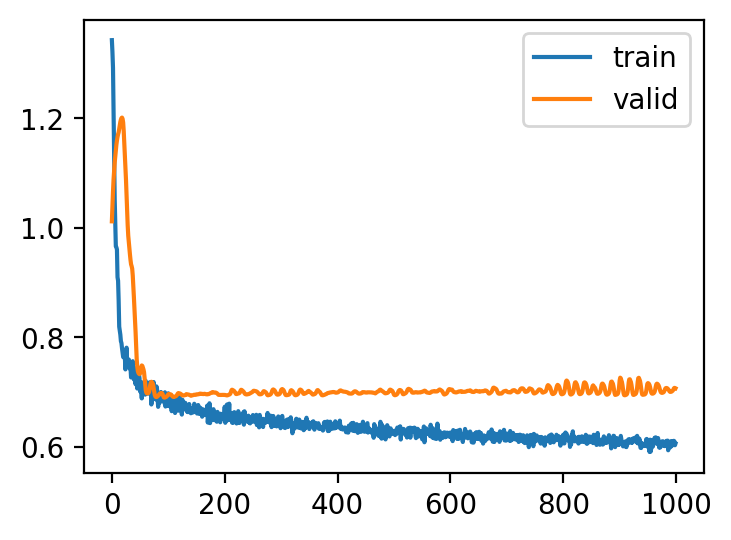

In [14]:
plt.figure(figsize=(4, 3), dpi=200)

x = [i for i in range(N_EPOCH)]
y = np.sqrt(np.array(trn_loss_history))
plt.plot(x, y, label='train')

x = [i for i in range(N_EPOCH)]
y = np.sqrt(np.array(val_loss_history))
plt.plot(x, y, label='valid')

plt.legend()
plt.show()

## ResNet

In [15]:
class BnLayer(nn.Module):
    def __init__(self, in_chan, out_chan, kernel_size=3, stride=1):
        super().__init__()
        self.conv = nn.Conv1d(in_chan, out_chan, kernel_size=kernel_size, stride=stride, padding=kernel_size//2, bias=False)
        self.bn = nn.BatchNorm1d(out_chan)
        self.activation = nn.PReLU()
        self.dropout = nn.Dropout(p=.2)
        
    def forward(self, x):
        return self.dropout(self.activation(self.bn(self.conv(x))))

    
class ResnetLayer(BnLayer):
    def forward(self, x):
        return x + super().forward(x)
    
class ResNet(nn.Module):
    def __init__(self, layers, D_out, kernel_size):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=kernel_size, stride=1, padding=kernel_size//2)
        self.bn1 = nn.BatchNorm1d(16)
        self.relu = nn.PReLU()
        self.maxpool = nn.MaxPool1d(kernel_size=kernel_size, stride=1, padding=kernel_size//2)
        self.layers1 = nn.ModuleList([BnLayer(layers[i], layers[i+1], kernel_size=kernel_size) for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i+1], kernel_size, stride=1) for i in range(len(layers) - 1)])
        self.layers3 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i+1], kernel_size, stride=1) for i in range(len(layers) - 1)])
#         self.dropout = nn.Dropout(p=.2)
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.output_layer = nn.Linear(layers[-1], D_out)
        
    def forward(self, x):
        x = x.view(-1, 1, x.size(1))
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        for layer1, layer2, layer3 in zip(self.layers1, self.layers2, self.layers3):
            x = layer3(layer2(layer1(x)))
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        return self.output_layer(x)

In [16]:
layers = [16, 16]
D_out = 1
kernel_size = 3
N_EPOCH = 1000
model = ResNet(layers, D_out, kernel_size)
print(count_parameters(model), count_trainable_parameters(model))

2517 2517


In [17]:
# 特徴量の数が不明でもConvから入れば問題ない

# ここのConvのchannel数は、考えないといけなさそう
# LAYERS = [10, 20, 40, 80]
# OUT_DIM = 1

max_lr = 0.00025
base_lr = 0.00004

loss_func = nn.MSELoss()
# loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=base_lr)
scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr, max_lr, step_size_up=4, cycle_momentum=False)

In [18]:
lr_history = []
val_loss_history = []
trn_loss_history = []

def validate():
    model.eval()
    with torch.no_grad():
        inputs = inps_test.float().to(DEVICE)
        targets = tgts_test.float().to(DEVICE)          
        outputs = model(inputs)

        loss = loss_func(outputs, targets)
    return loss.item()

for epoch in range(N_EPOCH):
    model.train()
    
    inputs = inps_train.float().to(DEVICE)
    targets = tgts_train.float().to(DEVICE)
    optimizer.zero_grad()

    outputs = model(inputs)

    loss = loss_func(outputs, targets)
    loss.backward()

    optimizer.step()
    
    lr_step = optimizer.state_dict()["param_groups"][0]["lr"]
    lr_history.append(lr_step)
    scheduler.step()
    
    trn_loss_history.append(loss.item())
    val_loss = validate()
    val_loss_history.append(val_loss)

    if epoch % 100 == 99:        
        print(f'Epoch: [{epoch+1}/{N_EPOCH}], Loss: {np.sqrt(loss.item()):.4f}, Validation loss:{np.sqrt(val_loss):.4f}')

print('Finish training')


# print(f"Validation loss:{np.sqrt(loss.item()):.4f}")

Epoch: [100/1000], Loss: 0.6977, Validation loss:0.7101
Epoch: [200/1000], Loss: 0.6752, Validation loss:0.6933
Epoch: [300/1000], Loss: 0.6640, Validation loss:0.6886
Epoch: [400/1000], Loss: 0.6658, Validation loss:0.6864
Epoch: [500/1000], Loss: 0.6622, Validation loss:0.6855
Epoch: [600/1000], Loss: 0.6482, Validation loss:0.6849
Epoch: [700/1000], Loss: 0.6623, Validation loss:0.6839
Epoch: [800/1000], Loss: 0.6561, Validation loss:0.6840
Epoch: [900/1000], Loss: 0.6500, Validation loss:0.6837
Epoch: [1000/1000], Loss: 0.6521, Validation loss:0.6830
Finish training


過学習気味  
もっとlayerを薄くした方がいい

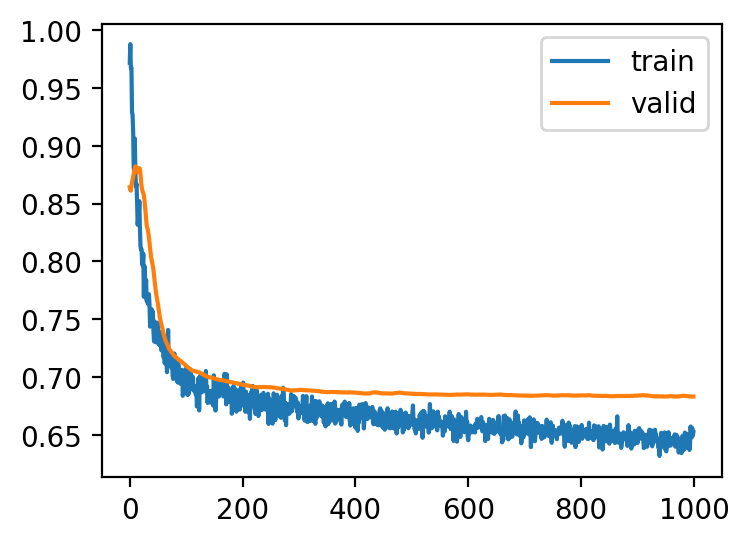

In [19]:
plt.figure(figsize=(4, 3), dpi=200)

x = [i for i in range(N_EPOCH)]
y = np.sqrt(np.array(trn_loss_history))
plt.plot(x, y, label='train')

x = [i for i in range(N_EPOCH)]
y = np.sqrt(np.array(val_loss_history))
plt.plot(x, y, label='valid')

plt.legend()
plt.show()